<a href="https://colab.research.google.com/github/ManishKumarDhillon/Image-Segmentation-CNN-elctron-micrographs/blob/main/U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=a5e5331c53c6e8d6d71a6a1cf67db498213d4010c80efbff522a65c02c545bc3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=c0d320d75a6846c0d0ae8b845e25b1a0655491641e7ff3293671ca150de988e8
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
CSV_FILE="/content/drive/MyDrive/MTP/train1.csv"
DATA_DIR="/content/drive/MyDrive/MTP/"
DEVICE = 'cuda'
EPOCHS=40
LR = 0.003
BATCH_SIZE = 16
IMG_SIZE = 320

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,/content/drive/MyDrive/MTP/Ground_Truth/1.png,/content/drive/MyDrive/MTP/Training_Images/1.png
1,/content/drive/MyDrive/MTP/Ground_Truth/2.png,/content/drive/MyDrive/MTP/Training_Images/2.png
2,/content/drive/MyDrive/MTP/Ground_Truth/3.png,/content/drive/MyDrive/MTP/Training_Images/3.png
3,/content/drive/MyDrive/MTP/Ground_Truth/4.png,/content/drive/MyDrive/MTP/Training_Images/4.png
4,/content/drive/MyDrive/MTP/Ground_Truth/5.png,/content/drive/MyDrive/MTP/Training_Images/5.png


In [ ]:
row = df.iloc[1]
image_path=row.images
mask_path = row.masks
image  = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

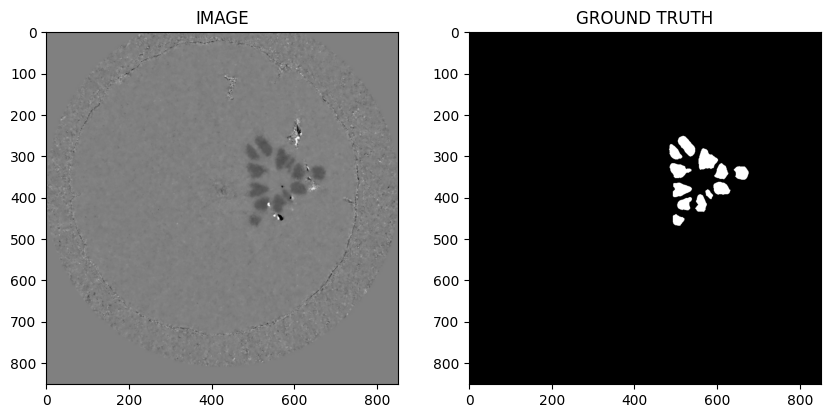

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df= train_test_split(df,test_size = 0.2,random_state = 42)

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

In [ ]:
#to get the image and mask im ac to index is the reason to create the custom dataset
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentation):
    self.df = df
    self.augmentation = augmentation
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    image_path=row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))

    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #SHAPE OF (h,w,c)
    mask = cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
    mask = np.expand_dims(mask , axis = -1)

    if self.augmentation:
      data = self.augmentation(image = image ,mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c)--->(c,h,w) pytorch format
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask))/255.0
    return image , mask

In [ ]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 32
Size of Validset : 8


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')



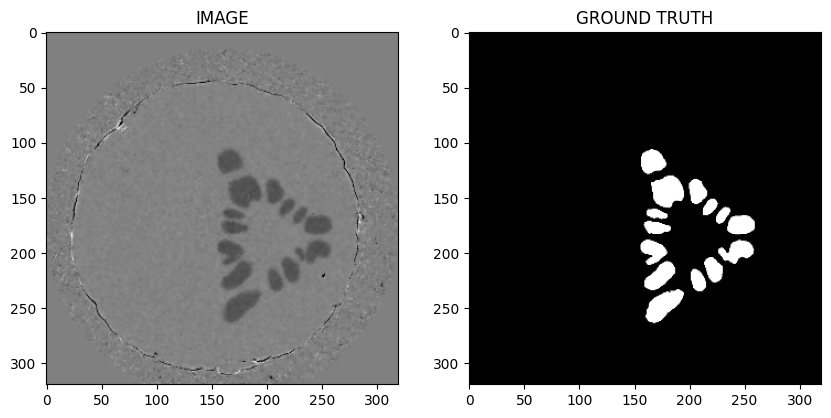

In [ ]:
idx = 4
image ,mask= trainset[idx]
show_image(image,mask)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE ,shuffle =True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE,shuffle = True)

In [ ]:
print("total no. of batches in trainloader",len(trainloader))
print("total no. of batches in validloader",len(validloader))


total no. of batches in trainloader 2
total no. of batches in validloader 1


In [ ]:
for image,mask in(trainloader):
  break
print("One batch image shape",(image.shape))
print("One batch mask shape",(mask.shape))

One batch image shape torch.Size([16, 3, 320, 320])
One batch mask shape torch.Size([16, 1, 320, 320])


In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3,
        classes = 1,
        activation = None

    )

  def forward(self,images,masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode= 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits,loss1 +loss2
    return logits

In [ ]:
model =   SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 117MB/s] 


In [ ]:
# def train_fn(data_loader,model,optimizer):
#   model.train()
#   total_loss = 0.0
#   for images,masks in tqdm(data_loader):
#     images = images.to(DEVICE)
#     masks = masks.to(DEVICE)
#     optimizer.zero_grad()
#     logits,loss = model(images,masks)
#     loss.backward()
#     optimizer.step()
#     total_loss+= loss.item()
#   return total_loss/len(data_loader)


In [ ]:
def calculate_iou(pred_mask, true_mask):
    pred_mask = pred_mask.detach().cpu().squeeze(0).numpy()  # Move to CPU and convert to NumPy array
    true_mask = true_mask.detach().cpu().squeeze(0).numpy()  # Move to CPU and convert to NumPy array

    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = np.logical_or(true_mask, pred_mask).sum()

    iou = intersection / union if union > 0 else 0.0  # Avoid division by zero
    return iou


In [ ]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits = model(images)
        preds = (torch.sigmoid(logits) > 0.5).float()

        # Calculate IoU for each batch
        for i in range(len(images)):
            total_iou += calculate_iou(preds[i], masks[i].squeeze())

        # Calculate loss
        logits,loss = model(images,masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += images.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / total_samples
    return avg_loss, avg_iou


In [ ]:
# def eval_fn(data_loader,model):
#   model.eval()
#   total_loss = 0.0
#   for images, masks in tqdm(data_loader):
#     images = images.to(DEVICE)
#     masks = masks.to(DEVICE)
#     # optimizer.zero_grad()
#     logits,loss = model(images,masks)
#     # loss.backward()
#     # optimizer.step()
#     total_loss+= loss.item()
#   return total_loss/len(data_loader)


In [ ]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        with torch.no_grad():
            logits = model(images)
            preds = (torch.sigmoid(logits) > 0.5).float()

            # Calculate IoU for each batch
            for i in range(len(images)):
                total_iou += calculate_iou(preds[i], masks[i].squeeze())

        # Calculate loss for each batch
        logits, loss = model(images, masks)
        total_loss += loss.item()
        total_samples += images.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / total_samples
    return avg_loss, avg_iou


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [ ]:
loss_train=[]
loss_valid=[]
train_iou=[]
valid_iou=[]
iteration=[]

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss,iou_train = train_fn(trainloader,model,optimizer)
  valid_loss,iou_valid = eval_fn(validloader,model)
  loss_train.append(train_loss)
  loss_valid.append(valid_loss)
  train_iou.append(iou_train)
  valid_iou.append(iou_valid)
  iteration.append(i+1)


  if valid_loss <best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("saved model")
    best_valid_loss = valid_loss



  print(f"Epoch :{i+1} Train Loss:{train_loss}  Valid_Loss: {valid_loss} Iou_train: {iou_train} Iou_valid: {iou_valid}")



100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


saved model
Epoch :1 Train Loss:2.178505063056946  Valid_Loss: 2.3253331184387207 Iou_train: 0.04602936110054187 Iou_valid: 0.05793349344432413


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


saved model
Epoch :2 Train Loss:1.6650148034095764  Valid_Loss: 1.4376808404922485 Iou_train: 0.050757581336974646 Iou_valid: 0.0


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch :3 Train Loss:1.4747450947761536  Valid_Loss: 1.5946660041809082 Iou_train: 0.22026471096185313 Iou_valid: 0.010803067978472004


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch :4 Train Loss:1.385544776916504  Valid_Loss: 1.508427381515503 Iou_train: 0.4955951489513015 Iou_valid: 0.13119533789941326


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch :5 Train Loss:1.3172077536582947  Valid_Loss: 1.5123348236083984 Iou_train: 0.6631470907131525 Iou_valid: 0.180803573446086


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch :6 Train Loss:1.24518483877182  Valid_Loss: 1.449038028717041 Iou_train: 0.7403697965356881 Iou_valid: 0.1822379099399583


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


saved model
Epoch :7 Train Loss:1.1647568941116333  Valid_Loss: 1.2695776224136353 Iou_train: 0.7683579401286835 Iou_valid: 0.43119570638561894


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


saved model
Epoch :8 Train Loss:1.0794012546539307  Valid_Loss: 1.1854881048202515 Iou_train: 0.7737536793827758 Iou_valid: 0.5782153761583053


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch :9 Train Loss:0.9620184302330017  Valid_Loss: 1.2086591720581055 Iou_train: 0.770113690585636 Iou_valid: 0.43764969283018285


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


saved model
Epoch :10 Train Loss:0.8437950611114502  Valid_Loss: 1.1369638442993164 Iou_train: 0.7829052551547381 Iou_valid: 0.2991397315044669


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


saved model
Epoch :11 Train Loss:0.7526061832904816  Valid_Loss: 1.0484631061553955 Iou_train: 0.8053818081988772 Iou_valid: 0.4540970322940435


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


saved model
Epoch :12 Train Loss:0.6550295948982239  Valid_Loss: 0.8808532953262329 Iou_train: 0.8156122949131817 Iou_valid: 0.6639554243793595


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


saved model
Epoch :13 Train Loss:0.5651577413082123  Valid_Loss: 0.6887533068656921 Iou_train: 0.8083558737352877 Iou_valid: 0.7622479374585347


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


saved model
Epoch :14 Train Loss:0.4831569194793701  Valid_Loss: 0.5334883332252502 Iou_train: 0.8176731293678506 Iou_valid: 0.7932466004053079


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


saved model
Epoch :15 Train Loss:0.4025614261627197  Valid_Loss: 0.4178001284599304 Iou_train: 0.8316586609778234 Iou_valid: 0.8028659299773386


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


saved model
Epoch :16 Train Loss:0.3465423732995987  Valid_Loss: 0.3330502510070801 Iou_train: 0.8256775402406624 Iou_valid: 0.8261616754669904


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


saved model
Epoch :17 Train Loss:0.28373217582702637  Valid_Loss: 0.2687094211578369 Iou_train: 0.8335121078560146 Iou_valid: 0.8353249251514863


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


saved model
Epoch :18 Train Loss:0.24263297766447067  Valid_Loss: 0.211045041680336 Iou_train: 0.8267989600086658 Iou_valid: 0.8750983064622208


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


saved model
Epoch :19 Train Loss:0.19871099293231964  Valid_Loss: 0.18598252534866333 Iou_train: 0.832732503602289 Iou_valid: 0.8469909189987096


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


saved model
Epoch :20 Train Loss:0.1663198471069336  Valid_Loss: 0.1457827240228653 Iou_train: 0.8349049710803857 Iou_valid: 0.8801561222714656


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


saved model
Epoch :21 Train Loss:0.14225275814533234  Valid_Loss: 0.12838608026504517 Iou_train: 0.8426263899442467 Iou_valid: 0.8772779372070003


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


saved model
Epoch :22 Train Loss:0.135283961892128  Valid_Loss: 0.12101399898529053 Iou_train: 0.8338421471850685 Iou_valid: 0.8628893846196278


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


saved model
Epoch :23 Train Loss:0.11280735582113266  Valid_Loss: 0.10355129837989807 Iou_train: 0.8278709116072316 Iou_valid: 0.8801820640076197


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


saved model
Epoch :24 Train Loss:0.10380014777183533  Valid_Loss: 0.09017489850521088 Iou_train: 0.8437885931288572 Iou_valid: 0.9065167829508073


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


saved model
Epoch :25 Train Loss:0.09232649952173233  Valid_Loss: 0.0890330895781517 Iou_train: 0.8472508446156236 Iou_valid: 0.8809802284544983


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


saved model
Epoch :26 Train Loss:0.08714746311306953  Valid_Loss: 0.07778234034776688 Iou_train: 0.8296776726995839 Iou_valid: 0.9000680822068512


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


saved model
Epoch :27 Train Loss:0.08635125681757927  Valid_Loss: 0.0733131468296051 Iou_train: 0.8354699558978007 Iou_valid: 0.9053157206014538


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


saved model
Epoch :28 Train Loss:0.08036524802446365  Valid_Loss: 0.06817836314439774 Iou_train: 0.8435969289341474 Iou_valid: 0.9066572971783482


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


saved model
Epoch :29 Train Loss:0.07279933989048004  Valid_Loss: 0.06550990045070648 Iou_train: 0.8466493454120372 Iou_valid: 0.9123985478659655


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


saved model
Epoch :30 Train Loss:0.0733724869787693  Valid_Loss: 0.06447026133537292 Iou_train: 0.8377086107356118 Iou_valid: 0.9061253093018342


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


saved model
Epoch :31 Train Loss:0.06796569749712944  Valid_Loss: 0.06347658485174179 Iou_train: 0.8390129799893128 Iou_valid: 0.9138133288722946


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


saved model
Epoch :32 Train Loss:0.0649527832865715  Valid_Loss: 0.059824492782354355 Iou_train: 0.8533011891226657 Iou_valid: 0.9196977499751042


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


saved model
Epoch :33 Train Loss:0.06347546353936195  Valid_Loss: 0.05716036632657051 Iou_train: 0.850382782986381 Iou_valid: 0.9134519703555084


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch :34 Train Loss:0.06178508885204792  Valid_Loss: 0.058412402868270874 Iou_train: 0.8449640930156983 Iou_valid: 0.9151591887789877


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


saved model
Epoch :35 Train Loss:0.061738867312669754  Valid_Loss: 0.05559258162975311 Iou_train: 0.844745955521823 Iou_valid: 0.919048834688105


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch :36 Train Loss:0.05887223407626152  Valid_Loss: 0.05966763198375702 Iou_train: 0.8554557825701061 Iou_valid: 0.9187320189921535


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


saved model
Epoch :37 Train Loss:0.0566561222076416  Valid_Loss: 0.053404439240694046 Iou_train: 0.8580452130028713 Iou_valid: 0.9143134993548157


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


saved model
Epoch :38 Train Loss:0.05691104382276535  Valid_Loss: 0.05193694308400154 Iou_train: 0.8415565740334592 Iou_valid: 0.9168318787715217


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch :39 Train Loss:0.055033426731824875  Valid_Loss: 0.05326550453901291 Iou_train: 0.8547013161945596 Iou_valid: 0.9221486385763906


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

saved model
Epoch :40 Train Loss:0.053486546501517296  Valid_Loss: 0.05060770362615585 Iou_train: 0.8586406774459842 Iou_valid: 0.9209244772514932


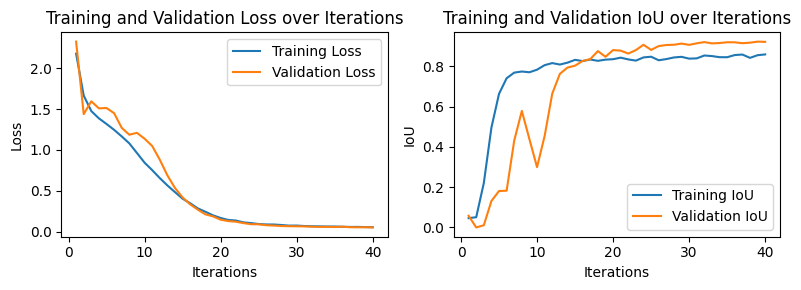

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

# Plotting loss
axs[0].plot(iteration, loss_train, label='Training Loss')
axs[0].plot(iteration, loss_valid, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Iterations')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting IoU
axs[1].plot(iteration, train_iou, label='Training IoU')
axs[1].plot(iteration, valid_iou, label='Validation IoU')
axs[1].set_title('Training and Validation IoU over Iterations')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('IoU')
axs[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
idx = 4

#here we are going to use valid set as test set
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

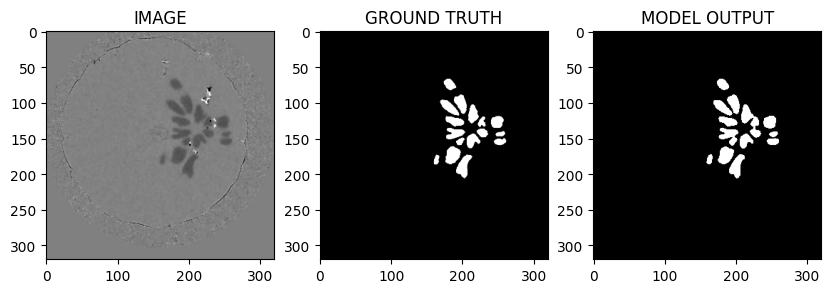

In [ ]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))